In [2]:
import numpy as np
import scipy as sp
import scipy.special as sc
from scipy.integrate import quad
import mpmath as mp
import pandas as pd
import matplotlib.pyplot as plt
from gw_lens_dir.L_unlensed import Lunlensed
from gw_lens_dir.overlap_lensing_geo_wave import overlap_dual_ann_lensing_geo_wave
from gw_lens_dir.overlap_lensing_changed_param import overlap_dual_ann_lensing
%matplotlib inline

## Overlap (geo vs wave optics)

Calculating the overlap between lensed strain in wave optics and geometrical optics regime. This analysis will be helpful to obtain the time delay related to different lens model such as point mass, sis etc


In [3]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec

def mag(ml, y, lens):
    
    if lens == 'pm':
        mu_plus = np.abs(0.5 + (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
        mu_minus = np.abs(0.5 - (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
    
    elif lens == 'sis':
        mu_plus = np.abs(1 + 1 / y)
        mu_minus = np.abs(-1 + 1 / y)
    
    return mu_plus, mu_minus

def time_del(ml, y, lens):
    
    if lens == 'pm':
        first_term = (y * (y ** 2 + 4) ** 0.5) / 2
        second_term = np.log(((y ** 2 + 4) ** 0.5 + y) / ((y ** 2 + 4) ** 0.5 - y))
        tds = 4 * ml * (first_term + second_term)
    
    elif lens == 'sis':
        tds = 8 * ml * y
    
    return tds

In [3]:
print(f'magntifications: {mag(1e3 * solar_mass, 0.8, "pm")}  \
      \n flux ratio: {mag(1e3 * solar_mass, 0.8, "pm")[1] / mag(1e3 * solar_mass, 0.8, "pm")[0]}')
print(f'time delay: {time_del(1e4 * solar_mass, 0.5, "pm")}')

magntifications: (1.265993269980339, 0.2659932699803388)        
 flux ratio: 0.21010638546638538
time delay: 0.1990834045220832


In [8]:
class overlap_lens_prop():

    def __init__(self, params_source = None, params_temp = None):
        
        self.params_source = params_source
        self.params_temp = params_temp

        # Defining source parameters with (t0, phi0)
        self.theta_s_source = params_source['theta_s_source']
        self.phi_s_source = params_source['phi_s_source']
        self.theta_l_source = params_source['theta_l_source']
        self.phi_l_source = params_source['phi_l_source']
        self.mcz_source = params_source['mcz_source']
        self.dist_source = params_source['dist_source']
        self.eta_source = params_source['eta_source']
        self.t0 = params_source['t0']
        self.phi_0 = params_source['phi_0']
        
        # Adding the lensing params for source
        #self.td = params_source['td']
        #self.flux_ratio = params_source['flux_ratio']
        self.M_lz_source = params_source['M_lz_source']
        self.y_source = params_source['y_source']
        
        
        # Defining template parameters 
        self.theta_s_temp = params_temp['theta_s_temp']
        self.phi_s_temp = params_temp['phi_s_temp']
        self.theta_l_temp = params_temp['theta_l_temp']
        self.phi_l_temp = params_temp['phi_l_temp']
        self.mcz_temp = params_temp['mcz_temp']
        self.dist_temp = params_temp['dist_temp']
        self.eta_temp = params_temp['eta_temp']
        self.tc = params_temp['tc']
        self.phi_c = params_temp['phi_c']
        
        # Adding the lensing paramters for template
        self.M_lz_temp = params_temp['M_lz_temp']
        self.y_temp = params_temp['y_temp']
        
        

    def limit(self, params_source, params_template):
    
        low_limit = 20
        f_cut_source = 1 / (np.power(6, 3/2) * np.pi * ((self.mcz_source) / (np.power(self.eta_source, 3/5))))
        f_cut_temp = 1 / (np.power(6, 3/2) * np.pi * ((self.mcz_temp) / (np.power(self.eta_temp, 3/5))))

        if f_cut_temp < f_cut_source:
            upper_limit = f_cut_temp

        else:
            upper_limit = f_cut_source
        
        return low_limit, upper_limit, f_cut_source, f_cut_temp

    def strain(self, f, theta_s, phi_s, theta_l, phi_l, mcz, dist, eta, tc, phi_c):
        """
        This file is just functionized form of L_unlensed(which was "object-oriented"). This was mainly created
        for the optimization of overlap function.
        """
        def mass_conv(mcz, eta):
            """Converts chirp mass to total mass. M = mcz/eta^(3/5)
            """

            M_val = mcz/np.power(eta, 3/5)
            return M_val

        def l_dot_n(theta_s, theta_l, phi_s, phi_l):
            """TODO
            """

            cos_term = np.cos(theta_s) * np.cos(theta_l)
            sin_term = np.sin(theta_s) * np.sin(theta_l) * np.cos(phi_s - phi_l)

            inner_prod = cos_term + sin_term
            return inner_prod

        def amp(mcz, dist):
            """TODO
            """

            amplitude = np.sqrt(5 / 96) * np.power(np.pi, -2 / 3) * np.power(mcz, 5 / 6) / (dist)
            return amplitude

        def psi(f, tc, phi_c, mcz, eta):
            """eqn 3.13 in Cutler-Flanaghan 1994
            """

            front_terms = 2 * np.pi * f * tc - phi_c - np.pi / 4
            main_coeffs = 0.75 * np.power(8 * np.pi * mcz * f, -5 / 3)
            main_terms = (1 + 20 / 9 * (743 / 336 + 11 / 4 * eta) * np.power(np.pi * mass_conv(mcz, eta) * f, 2 / 3)
                            - (16 * np.pi) * np.power(np.pi * mass_conv(mcz, eta) * f, 1))

            psi_val = front_terms + main_coeffs * (main_terms)
            return psi_val

        def psi_s(theta_s, theta_l, phi_s, phi_l):

            numerator = np.cos(theta_l)-np.cos(theta_s)*(l_dot_n(theta_s, theta_l, phi_s, phi_l))
            denominator = np.sin(theta_s)*np.sin(theta_l)*np.sin(phi_l-phi_s)

            psi_s_val = np.arctan2(numerator, denominator)
            return psi_s_val


        def fIp(theta_s, phi_s):
            """TODO
            """

            term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)* np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
            term_2 = (np.cos(theta_s) * np.sin(2*phi_s)* np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

            fIp_val = term_1 - term_2
            return fIp_val

        def fIc(theta_s, phi_s):
            """TODO
            """

            term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)
                        * np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
            term_2 = (np.cos(theta_s) * np.sin(2*phi_s)
                        * np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

            fIc_val = term_1 + term_2
            return fIc_val

        def lambdaI():
            """TODO
            """

            term_1 = np.power(2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s), 2)
            term_2 = np.power((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s), 2)

            lambdaI_val = np.sqrt(term_1 + term_2)
            return lambdaI_val

        def phi_pI():
            """TODO
            """

            numerator = (2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s))
            denominator = ((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s))

            phi_pI_val = np.arctan2(numerator, denominator)
            return phi_pI_val

        term_1 = lambdaI()
        term_2 = (np.exp(-1j * phi_pI()))
        term_3 = amp(mcz, dist) * np.power(f, -7 / 6)
        term_4 = np.exp(1j * psi(f, tc, phi_c, mcz, eta))

        signal_I = term_1 * term_2 * term_3 * term_4
        return signal_I

    '''Adding in the lens
    '''

    '''Amplification factor in geometrical optics limit
    '''
    def F_pm(self, f):
        '''computes the amplification factor for source point mass lens.

        Parameters
        ----------
        f : float
            frequency

        y : float
            source position

        Return
        ----------
        F_val : float, complex
            Amplification factor for point mass
        '''

        w = 8 * np.pi * self.M_lz_source * f
        x_m = 0.5 * (self.y_source + np.sqrt(self.y_source**2 + 4))
        phi_m = np.power((x_m - self.y_source) , 2) / 2 - np.log(x_m)

        first_term = np.exp(np.pi * w / 4 + 1j * (w / 2) * (np.log(w / 2) - 2 * phi_m)) 
        second_term = sc.gamma(1 - 1j * (w / 2)) 
        third_term = mp.hyp1f1(1j * w / 2, 1, 1j * (w / 2) * (self.y_source**2), maxterms = 10**6)

        F_val_source = first_term * second_term * third_term
        F_val_source_pm = np.complex128(F_val_source, dtype = np.complex128)

        return F_val_source_pm
    
    def F_geo_pm(self, f):
        '''computes the amplification factor for source point mass lens in the geometrical optics limit (mismatch calculation only).

        Parameters
        ----------
        f : float
            frequency

        y : float
            source position

        Return
        ----------
        F_val : float, complex
            Amplification factor for point mass
        '''
        
        flux_ratio = mag(self.M_lz_temp, self.y_temp, lens = 'pm')[1] / mag(self.M_lz_temp, self.y_temp, lens = 'pm')[0]
        td = time_del(self.M_lz_temp, self.y_temp, lens = 'pm')
        
        F_geo_val_source_pm = (1 - 1j * np.sqrt(flux_ratio) * np.exp(2 * np.pi * 1j * f * td))
        F_geo_val_source_pm = np.sqrt(mag(self.M_lz_temp, self.y_temp, lens = 'pm')[0]) * F_geo_val_source_pm
        
        return F_geo_val_source_pm, flux_ratio, td

    def Sn(self, f):
        """ ALIGO noise curve from arXiv:0903.0338
        """
        fs = 20
        if f < fs:
            Sn_val = np.inf
        else:
            S0 = 1E-49
            f0 = 215
            Sn_temp = np.power(f/f0, -4.14) - 5 * np.power(f/f0, -2) + 111 * ((1 - np.power(f/f0, 2) + 0.5 * np.power(f/f0, 4)) / (1 + 0.5 * np.power(f/f0, 2)))
            Sn_val = Sn_temp * S0

        return Sn_val

    def signal_source(self, f): 
        
        hI_source = self.strain(
            f, 
            self.theta_s_source,
            self.phi_s_source, 
            self.theta_l_source,
            self.phi_l_source,
            self.mcz_source,
            self.dist_source,
            self.eta_source,
            self.t0,
            self.phi_0
        )

        amp_factor_source_pm = self.F_pm(f)

        return hI_source * amp_factor_source_pm

    def signal_temp(self, f): 

        hI_temp = self.strain(
            f, 
            self.theta_s_temp,
            self.phi_s_temp, 
            self.theta_l_temp,
            self.phi_l_temp,
            self.mcz_temp,
            self.dist_temp,
            self.eta_temp,
            self.tc,
            self.phi_c
        )
        amp_factor_temp_pm = self.F_geo_pm(f)
        
        return hI_temp * amp_factor_temp_pm[0]

    def integrand_1(self,f):

        integrand_1 = self.signal_source(f) * np.conjugate(self.signal_temp(f)) / self.Sn(f)

        return integrand_1
    
    def integrand_2(self, f):

        integrand_2 = self.signal_source(f) * np.conjugate(self.signal_source(f)) / self.Sn(f)

        return integrand_2

    def integrand_3(self, f):

        integrand_3 = self.signal_temp(f) * np.conjugate(self.signal_temp(f)) / self.Sn(f)

        return integrand_3

    def overlap(self):

        num_temp, num_err = quad(
            self.integrand_1, 
            self.limit(self.params_source, self.params_temp)[0], 
            self.limit(self.params_source, self.params_temp)[1]
        )

        deno_temp_1, deno_temp_err_1 = quad(
            self.integrand_2,
            self.limit(self.params_source, self.params_temp)[0], 
            self.limit(self.params_source, self.params_temp)[3]
        )

        deno_temp_2, deno_temp_err_2 = quad(
            self.integrand_3,
            self.limit(self.params_source, self.params_temp)[0], 
            self.limit(self.params_source, self.params_temp)[2]
        )
        
        num = 4 * np.real(num_temp)
        deno = np.sqrt((4 * np.real(deno_temp_1)) * (4 * np.real(deno_temp_2)))
        
        overlap_temp = num / deno
        
        return overlap_temp

In [13]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec
year = 31557600 #[year] = sec

initial_params_source = {
    'theta_s_source' : 0.0, 
    'phi_s_source' : 0.0, 
    'theta_l_source' : 0.0, 
    'phi_l_source' : 0.0, 
    'mcz_source' : 18.79 * solar_mass, 
    'dist_source': 1.58 * giga_parsec, 
    'eta_source' : 0.25, 
    't0' : 0.0, 
    'phi_0' : 0.0,
    'M_lz_source':1e2 * solar_mass,
    'y_source': 0.5
}

initial_params_template = {
    'theta_s_temp' : 0.0, 
    'phi_s_temp' : 0.0, 
    'theta_l_temp' : 0.0, 
    'phi_l_temp' : 0.0, 
    'mcz_temp' : 18.79 * solar_mass, 
    'dist_temp': 1.58 * giga_parsec, 
    'eta_temp' : 0.25, 
    'tc' : 0.0, 
    'phi_c' : 0.0,
    'M_lz_temp' : 1e4 * solar_mass,
    'y_temp' : 0.8
}

In [5]:
overlap_model = overlap_lens_prop(initial_params_source, initial_params_template)

NameError: name 'overlap_lens_prop' is not defined

Frequency at which advanced noise curve is minimum: 227.8787878787879 Hz


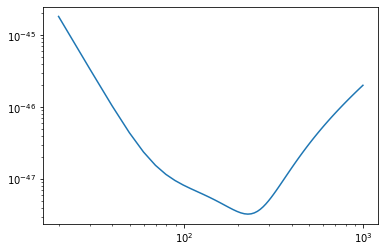

In [7]:
freq = np.linspace(20, 1000, 100)
noise = np.zeros_like(freq)

for i in range(freq.shape[0]):
    noise[i] = overlap_model.Sn(freq[i])

# minimum of the advanced noise curve
print(f"Frequency at which advanced noise curve is minimum: {freq[noise.argmin()]} Hz")

plt.loglog(freq, noise);

In [8]:
F_geo = overlap_model.F_geo_pm(40)
F_geo

((0.9347977136339571-0.4793266892818148j),
 0.21010638546638538,
 0.3234957887897611)

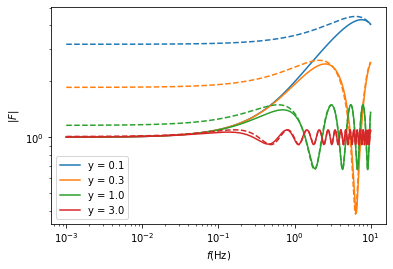

In [11]:
#plt.figure(figsize = (8, 5))
freq = my_lin(0.001, 10, 5000)
freq_arr = np.zeros_like(freq)
y_range = np.array([0.1, 0.3, 1, 3])
F_wave= np.zeros_like(freq, dtype = np.complex128)
F_geo = np.zeros_like(freq, dtype = np.complex128)
ax = plt.gca()

for y in y_range:
    params_template = initial_params_template
    params_template['y_temp'] = y
    params_source = initial_params_source
    params_source['y_source'] = y

    for i in range(freq.shape[0]):
        overlap_model = overlap_lens_prop(params_source, params_template)
        F_wave[i] = overlap_model.F_pm(freq[i])
        F_geo[i] = overlap_model.F_geo_pm(freq[i])[0]
        freq_arr[i] = freq[i]
    color = next(ax._get_lines.prop_cycler)['color']
    plt.loglog(freq_arr, np.abs(F_wave), label = f"y = {params_template['y_temp']}", color = color)
    plt.loglog(freq_arr, np.abs(F_geo), linestyle = '--', color = color)
    plt.ylabel('$|F|$')
    plt.xlabel('$f$(Hz)')
    plt.legend(loc = 'lower left')
#plt.savefig('amp_fac_pm.png', dpi = 100, bbox_inches = 'tight')

The amplification factor in geometric optics is slightly shifted down along y axis because we are missing coefficient in front of the amplication factor, which is a square root of plus magnification. This is due to our change of variables from $(y, M_L) --> (I, t_d)$. This change of variable affects the strain in geometrical optics regime but keeps the overlap unchanged.

In [5]:
# Custom array generator for uneven spaced lens mass. This is required in order to get more data points at the critical point. 
# (https://stackoverflow.com/questions/32504766/python-generate-unevenly-spaced-array)

def my_lin(lb, ub, steps, spacing = 7.5):
    span = (ub-lb)
    dx = 1.0 / (steps-1)
    return np.array([lb + (i * dx) ** spacing * span for i in range(steps)])

lin = my_lin(0.005e1 * solar_mass, 2e4 * solar_mass, 20)

### Time delay behavior wrt $M_L$

In [52]:
#ml_range = np.linspace(0.05e1 * solar_mass, 2e4 * solar_mass, 50)
#ml_range = lin
#ml_range = np.logspace(2.5, 4, 20) * solar_mass
y_range = np.linspace(0.1, 1, 20)
td = np.zeros_like(ml_range)

for i in range(len(ml_range)):
    td[i] = time_del(2e4 * solar_mass, y_range[i], lens = 'pm')
td

array([0.07885268, 0.11626059, 0.15373348, 0.19129205, 0.22895687,
       0.26674833, 0.30468665, 0.34279176, 0.38108336, 0.41958088,
       0.45830341, 0.49726973, 0.53649825, 0.57600703, 0.61581375,
       0.65593567, 0.69638969, 0.73719226, 0.77835943, 0.81990682])

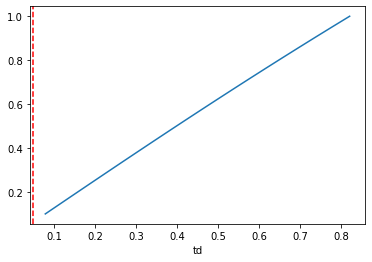

In [53]:
#plt.plot(td, ml_range / solar_mass, marker = 'x')
plt.plot(td, y_range)
plt.axvline(x=0.05, color='r', linestyle='--')
plt.xlabel('td')
#plt.ylabel('$m_L$')
plt.show()

In [23]:
td[:2]

array([0.00629557, 0.00755062])

/Users/saifali/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:448: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


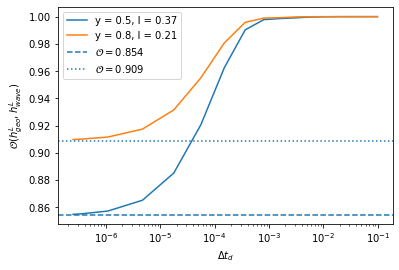

In [7]:
#ml_range = np.linspace(0.05e1 * solar_mass, 2e4 * solar_mass, 50)
ml_range = lin
#ml_range = np.logspace(0.05e1 * solar_mass, 2e4 * solar_mass, 50)
td = np.zeros_like(ml_range)
y_range = np.linspace(0.5, 0.8, 2)
overlap_lens_sig = np.zeros_like(ml_range)
fig, ax = plt.subplots()
#plt.figure(figsize = (10, 7))
for i in range(len(y_range)):
    params_temp = initial_params_template
    params_source = initial_params_source
    params_temp['y_temp'] = y_range[i]
    params_source['y_source'] = y_range[i]
    
    for i in range(len(ml_range)):
        params_temp['M_lz_temp'] = (ml_range[i])
        params_source['M_lz_source'] = (ml_range[i])
        model = overlap_lens_prop(params_source, params_temp)
        overlap_lens_sig[i] = model.overlap()
        td[i] = time_del(params_temp['M_lz_temp'], params_temp['y_temp'], lens = 'pm')
    ax.semilogx(ml_range, overlap_lens_sig, label = f"y = {params_temp['y_temp']}, I = {mag(params_temp['M_lz_temp'], params_temp['y_temp'], lens = 'pm')[1] / mag(params_temp['M_lz_temp'], params_temp['y_temp'], lens = 'pm')[0]:.2f}")
    plt.ylabel('$\mathcal{O}(h^L_{geo}, h^L_{wave})$')
    plt.xlabel('$\Delta t_d$')
    #plt.axvline(x = 0.05)
    #plt.axvline(x = 0.01)
    #plt.text(0.05,0.85,'$f_{low}^{-1}$', fontsize = 10)
    #plt.text(0.01,0.85,'$f_{cut}^{-1}$', fontsize = 10)
ax.axhline(y = 0.854, label = r'$\mathcal{O} = 0.854$', linestyle = '--')
ax.axhline(y = 0.909, label = r'$\mathcal{O} = 0.909$', linestyle = 'dotted')
plt.legend(loc = 'best')
#plt.savefig('overlap-lensed-sigs-plateau.png', dpi = 100, bbox_inch = 'tight')

In [20]:
I = 0.37
1 / np.sqrt(1 + I)

0.854357657716761

Our goal is to calculate the $\mathcal{O}(h^{UL}, h^L)$ or $\epsilon$ for that matter, between unlensed and lensed signal. In order to do that we need to differentiate the wave optice and the geometrical optics regime properly. In the wave optics regime, we have to use the full amplification factor given in Takahashi/Nakamura whereas in the geometrical optics regime, we can use the summed amplification factor where it is valid only in the regime where $f \gg \Delta t_d^{-1}$. 

The amplification factor in geometrical optics, in terms of our parameters $(I, \Delta t_d)$ is given by $F(f) = |\mu_+|^{1/2} (1 - i I^{1/2} e^{2 \pi i f \Delta t_d})$. We know that for our aLIGO noise curve the floor of the frequency is at $20Hz$ and the $f_{cut}$ is given by the total mass. For our value of chirp mass $\mathcal{M} = 18.79 M_\odot$ and symmmetric mass ratio $\eta = 0.25$, the $f_{cut} ~ 100 Hz$. So, $f_{low} < f < f_{cut}$ or $f_{low}^{-1} > f > f_{cut}^{-1}$. 

Now in order to geometrical optics remain valid, $\Delta t_d >> f^{-1}$ and for our aLIGO noise curve, we can say that the lower limit on the time delay should be given by $\Delta t_d >> f_{low}^{-1}$. Now this means that from our figure above, the geometrical optics should be a good approximation (compared to wave optics) in the region right of the line at $f_{low}^{-1} = 0.05s$ because the $\mathcal{O}(h^L_{geo}, h^L_{wave}) \approx 1$. 

Since $\Delta t_d = \Delta t_d(M_L, y)$, the time delay depends on both the lens mass $M_L$ and the source position $y$ or the flux ratio $I = I(y)$. So we have to choose $M_L$ (and $y$) such that the $\Delta t_d \gg f_{low}^{-1}$. But if we want to see that transition from wave optics to geometrical optics, then we can choose $M_L$ (keeping $y$ constant) over a range where we can use wave optics as well as geometrical optics. Typically this means that we have to go at much smaller $M_L$, of the order $10^{-2} M_\odot$. 

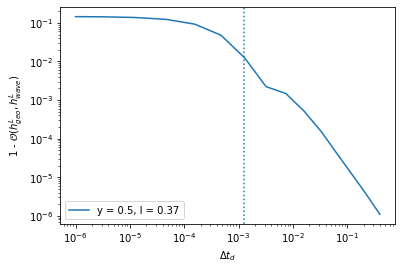

In [21]:
#ml_range = np.linspace(0.05e1 * solar_mass, 2e4 * solar_mass, 50)
ml_range = lin
td = np.zeros_like(ml_range)
y_range = np.linspace(0.5, 0.9, 1)
overlap_lens_sig = np.zeros_like(ml_range)

#plt.figure(figsize = (10, 7))
for i in range(len(y_range)):
    params_temp = initial_params_template
    params_source = initial_params_source
    params_temp['y_temp'] = y_range[i]
    params_source['y_source'] = y_range[i]
    
    for i in range(len(ml_range)):
        params_temp['M_lz_temp'] = ml_range[i]
        params_source['M_lz_source'] = ml_range[i]
        model = overlap_lens_prop(params_source, params_temp)
        overlap_lens_sig[i] = model.overlap()
        td[i] = time_del(params_temp['M_lz_temp'], params_temp['y_temp'], lens = 'pm')
    plt.loglog(td, 1 - overlap_lens_sig, label = f"y = {params_temp['y_temp']}, I = {mag(params_temp['M_lz_temp'], params_temp['y_temp'], lens = 'pm')[1] / mag(params_temp['M_lz_temp'], params_temp['y_temp'], lens = 'pm')[0]:.2f}")
    plt.ylabel('1 - $\mathcal{O}(h^L_{geo}, h^L_{wave})$')
    plt.xlabel('$\Delta t_d$')
    plt.legend(loc = 'lower left')
    plt.axvline(x = 1.28e-3, linestyle = 'dotted')
    #plt.text(0.05,1e-6,'$f_{low}^{-1}$', fontsize = 10)
#plt.savefig('1-overlap-lens-sigs.png', dpi = 100, bbox_inch = 'tight')

In [22]:
print(np.c_[td, 1 - overlap_lens_sig])

[[9.95417023e-07 1.45224367e-01]
 [9.95417038e-07 1.45224367e-01]
 [9.95438598e-07 1.45224349e-01]
 [9.96940810e-07 1.45223120e-01]
 [1.02666206e-06 1.45198845e-01]
 [1.32075608e-06 1.44963422e-01]
 [3.20209666e-06 1.43589727e-01]
 [1.21301698e-05 1.38281539e-01]
 [4.62430664e-05 1.23417548e-01]
 [1.56842080e-04 9.24930812e-02]
 [4.72136699e-04 4.80081484e-02]
 [1.28265991e-03 1.25274442e-02]
 [3.19660888e-03 2.23002072e-03]
 [7.40652904e-03 1.47338357e-03]
 [1.61258399e-02 5.11468624e-04]
 [3.32753300e-02 1.51375685e-04]
 [6.55265910e-02 3.97231594e-05]
 [1.23842105e-01 1.15034718e-05]
 [2.25691071e-01 3.52757849e-06]
 [3.98166809e-01 1.09009506e-06]]


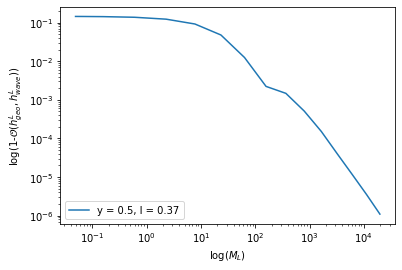

In [23]:
#ml_range = np.linspace(0.05e1 * solar_mass, 2e4 * solar_mass, 50)
ml_range = lin
td = np.zeros_like(ml_range)
y_range = np.linspace(0.5, 0.9, 1)
overlap_lens_sig = np.zeros_like(ml_range)

#plt.figure(figsize = (10, 7))
for i in range(len(y_range)):
    params_temp = initial_params_template
    params_source = initial_params_source
    params_temp['y_temp'] = y_range[i]
    params_source['y_source'] = y_range[i]
    
    for i in range(len(ml_range)):
        params_temp['M_lz_temp'] = ml_range[i]
        params_source['M_lz_source'] = ml_range[i]
        model = overlap_lens_prop(params_source, params_temp)
        overlap_lens_sig[i] = model.overlap()
        td[i] = time_del(params_temp['M_lz_temp'], params_temp['y_temp'], lens = 'pm')
    plt.loglog(ml_range * 2e5, 1 - overlap_lens_sig, label = f"y = {params_temp['y_temp']}, I = {mag(params_temp['M_lz_temp'], params_temp['y_temp'], lens = 'pm')[1] / mag(params_temp['M_lz_temp'], params_temp['y_temp'], lens = 'pm')[0]:.2f}")
    plt.ylabel('log(1-$\mathcal{O}(h^L_{geo}, h^L_{wave})$)')
    plt.xlabel('log($M_L$)')
    plt.legend(loc = 'lower left')
    

In [24]:
print(np.c_[ml_range * 2e5, 1 - overlap_lens_sig])

[[4.92624076e-02 1.45224367e-01]
 [4.92624083e-02 1.45224367e-01]
 [4.92634754e-02 1.45224349e-01]
 [4.93378186e-02 1.45223120e-01]
 [5.08087001e-02 1.45198845e-01]
 [6.53631824e-02 1.44963422e-01]
 [1.58469252e-01 1.43589727e-01]
 [6.00312588e-01 1.38281539e-01]
 [2.28853308e+00 1.23417548e-01]
 [7.76199151e+00 9.24930812e-02]
 [2.33656748e+01 4.80081484e-02]
 [6.34778328e+01 1.25274442e-02]
 [1.58197666e+02 2.23002072e-03]
 [3.66543312e+02 1.47338357e-03]
 [7.98055165e+02 5.11468624e-04]
 [1.64676998e+03 1.51375685e-04]
 [3.24285958e+03 3.97231594e-05]
 [6.12884861e+03 1.15034718e-05]
 [1.11692741e+04 3.52757849e-06]
 [1.97049630e+04 1.09009506e-06]]


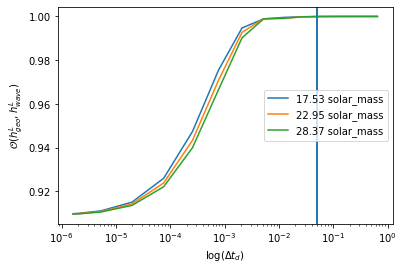

In [88]:
#ml_range = np.linspace(1e1 * solar_mass, 2e3 * solar_mass, 50)
ml_range = lin
td = np.zeros_like(ml_range)
mcz_range = np.linspace(17.79 * solar_mass, 28.79 * solar_mass, 3)
overlap_lens_sig = np.zeros_like(ml_range)

#plt.figure(figsize = (10, 7))
for i in range(len(mcz_range)):
    params_temp = initial_params_template
    params_source = initial_params_source
    params_temp['mcz_temp'] = mcz_range[i]
    params_source['mcz_source'] = mcz_range[i]
    
    for i in range(len(ml_range)):
        params_temp['M_lz_temp'] = ml_range[i]
        params_source['M_lz_source'] = ml_range[i]
        model = overlap_lens_prop(params_source, params_temp)
        overlap_lens_sig[i] = model.overlap()
        td[i] = time_del(params_temp['M_lz_temp'], params_temp['y_temp'], lens = 'pm')
    plt.semilogx(td, overlap_lens_sig, label = f"{params_temp['mcz_temp'] * 2e5:.2f} solar_mass")
    plt.ylabel('$\mathcal{O}(h^L_{geo}, h^L_{wave})$')
    plt.xlabel('log($\Delta t_d$)')
    plt.axvline(x = 0.05)
    plt.legend(loc = 5)

In [89]:
M_lz_source_range = np.linspace(0.5e1 * solar_mass, 1e2 * solar_mass, 10)
print(M_lz_source_range)

td = np.zeros_like(M_lz_source_range)
for i in range(M_lz_source_range.shape[0]):
    td[i] = time_del(M_lz_source_range[i], y = 0.8, lens = 'pm')

td

[2.46312038e-05 7.66304118e-05 1.28629620e-04 1.80628828e-04
 2.32628036e-04 2.84627244e-04 3.36626452e-04 3.88625660e-04
 4.40624868e-04 4.92624076e-04]


array([0.00016175, 0.00050322, 0.00084468, 0.00118615, 0.00152762,
       0.00186909, 0.00221055, 0.00255202, 0.00289349, 0.00323496])

In [145]:
def my_lin(lb, ub, steps, spacing = 6.5):
    span = (ub-lb)
    dx = 1.0 / (steps-1)
    return np.array([lb + (i * dx) ** spacing * span for i in range(steps)])

lin = my_lin(0.005e1 * solar_mass, 1e5 * solar_mass, 15)
lin * 2e5

array([4.92624076e-02, 5.27595489e-02, 3.65787505e-01, 4.46498046e+00,
       2.86978439e+01, 1.22234351e+02, 3.99714437e+02, 1.08860442e+03,
       2.59302286e+03, 5.57562207e+03, 1.10589811e+04, 2.05478636e+04,
       3.61736116e+04, 6.08618741e+04, 9.85248152e+04])

In [5]:
data_path = '/Users/saifali/Desktop/gwlensing/data/'

In [26]:
data_file = 'overlap_lensing_ml_y=0.5_mcz=18.79.csv'
df_1 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_1['match'] = np.array([-df_1[1][i][0] for i in range(len(df_1))])
df_1['td'] = np.array([time_del(df_1[0][i], y = 0.5, lens = 'pm') for i in range(len(df_1))])
df_1[0] = np.array(df_1[0] * 2e5)
df_1 = df_1.sort_values(by = 0)
#df_1

In [27]:
data_file = 'overlap_lensing_ml_y=0.5_mcz=18.79_v1.csv'
df_2 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_2['match'] = np.array([-df_2[1][i][0] for i in range(len(df_2))])
df_2['td'] = np.array([time_del(df_2[0][i], y = 0.5, lens = 'pm') for i in range(len(df_2))])
df_2[0] = np.array(df_2[0] * 2e5)
df_2 = df_2.sort_values(by = 0)

/Users/saifali/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/saifali/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/saifali/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 0, '$log(\\Delta t_d)$')

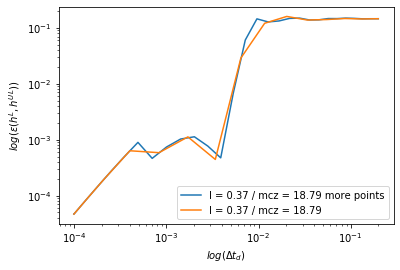

In [28]:
plt.loglog(df_2['td'], 1 - df_2['match'], label = 'I = 0.37 / mcz = 18.79 more points')
plt.loglog(df_1['td'], 1 - df_1['match'], label = 'I = 0.37 / mcz = 18.79')
plt.legend(loc = 4)
#plt.xlim(0.01, 1)
plt.ylabel('$log(\epsilon(h^L, h^{UL}))$')
plt.xlabel('$log(\Delta t_d)$')

In [68]:
data_file = 'overlap_lensing_ml_y=0.8_mcz=18.79.csv'
df_3 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_3['match'] = np.array([-df_3[1][i][0] for i in range(len(df_3))])
df_3['td'] = np.array([time_del(df_3[0][i], y = 0.5, lens = 'pm') for i in range(len(df_3))])
df_3[0] = np.array(df_3[0] * 2e5)
df_3 = df_3.sort_values(by = 0)

Text(0.5, 0, '$\\Delta t_d$')

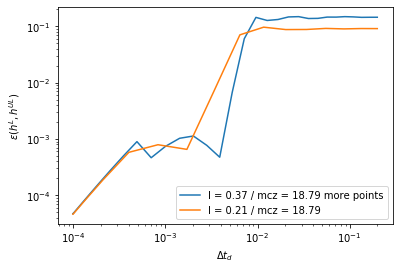

In [71]:
plt.loglog(df_2['td'], 1 - df_2['match'], label = 'I = 0.37 / mcz = 18.79 more points')
plt.loglog(df_3['td'], 1 - df_3['match'], label = 'I = 0.21 / mcz = 18.79')
plt.legend(loc = 4)
#plt.ylim(5e-2, 1)
#plt.xlim(1e-2, 1)
plt.ylabel('$\epsilon(h^L, h^{UL})$')
plt.xlabel('$\Delta t_d$')

In [48]:
M_lz_source_range = my_lin(0.5e1 * solar_mass, 1e4 * solar_mass, 20)
M_lz_source_range

array([2.46312038e-05, 2.46312038e-05, 2.46312065e-05, 2.46313922e-05,
       2.46350676e-05, 2.46714357e-05, 2.49040851e-05, 2.60081439e-05,
       3.02265954e-05, 4.39034338e-05, 8.28932350e-05, 1.83123740e-04,
       4.19805515e-04, 9.40410500e-04, 2.01865344e-03, 4.13938488e-03,
       8.12762375e-03, 1.53390069e-02, 2.79338015e-02, 4.92624076e-02])

In [60]:
'''
change the time delay to higher values and change the wave optics limit (time delay limit)
change the resolution(increasing the number of points)

------>

do it for different I (same lens)
do it for different lens (same I)
'''

'\nchange the time delay to higher values and change the wave optics limit (time delay limit)\nchange the resolution(increasing the number of points)\n\n------>\n\ndo it for different I (same lens)\ndo it for different lens (same I)\n'

In [6]:
data_file = 'overlap_pm_ml_y=0.5.csv'
df_pm = pd.read_csv(data_path + data_file)
#df_pm = df_pm.drop([18])

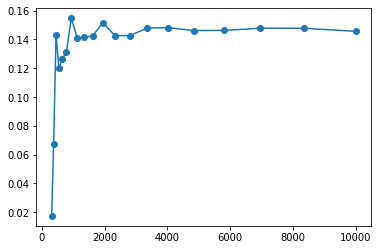

In [8]:
plt.plot(np.array(df_pm['M_lz'] / solar_mass), 1 - np.array(df_pm['overlap']), marker = 'o')

In [111]:
M_lz_source_range = np.logspace(2.5, 4, 20) * solar_mass
M_lz_source_range / solar_mass

array([  316.22776602,   379.26901907,   454.8777947 ,   545.55947812,
         654.31891297,   784.75997035,   941.20496727,  1128.83789168,
        1353.87618002,  1623.77673919,  1947.48303991,  2335.72146909,
        2801.3567612 ,  3359.81828628,  4029.6113202 ,  4832.93023857,
        5796.39395338,  6951.92796178,  8337.82223472, 10000.        ])

In [59]:
data_file = 'overlap_pm_y_ml=1e3.csv'
df_pm = pd.read_csv(data_path + data_file)
df_pm

,M_lz,overlap,tc,phi_c
0,0.100000,0.732450,-0.000025,-0.003395
1,0.147368,0.754050,0.000127,0.038029
2,0.194737,0.774622,0.000100,0.032155
3,0.242105,0.789216,0.000015,0.008914
4,0.289474,0.800751,-0.000068,-0.021867
5,0.336842,0.812521,-0.000082,-0.030659
6,0.384211,0.824939,-0.000022,-0.009174
7,0.431579,0.837128,0.000038,0.014569
8,0.478947,0.848675,0.000050,0.018543
9,0.526316,0.859642,0.000032,0.010329


In [65]:
flux_ratio = mag(2e4 * solar_mass, df_pm['M_lz'], "pm")[1] / mag(2e4 * solar_mass, df_pm['M_lz'], "pm")[0]

def mismatch(I):
    return 1 - ((1 + I) ** (-1/2))
I = np.linspace(0.1, 1, 100)
eps = np.zeros_like(I)

for i in range(len(I)):
    eps[i] = mismatch(I[i])

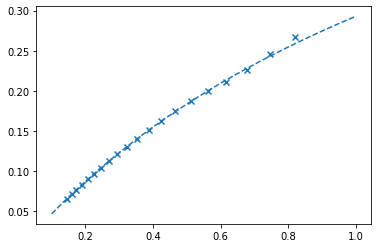

In [76]:
plt.plot(I, eps, '--')
plt.scatter(np.array(flux_ratio), 1 - np.array(df_pm['overlap']), marker = 'x')